In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense,LSTM,Dropout
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
import requests
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [3]:
# Database related all the code is moved to this file
%run -i "SqlConn.py"
#importing local py file
import SqlConn 

In [4]:
#Fetch Tweets and Sentiment data - Join from Tweet and Sentiment tables
try:
    df_dbFinanceData = SqlConn.fetchFinanceData("")
    print("Data transfer Done")
except BaseException as err:
    print(err)

Data transfer Done


In [5]:
df_dbFinanceData

,financeType,date,open,high,low,close,adjustedClose,volume,id
0,tesla,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500,1
1,tesla,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500,2
2,tesla,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000,3
3,tesla,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000,4
4,tesla,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500,5
...,...,...,...,...,...,...,...,...,...
6916,doge,2022-07-09,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917
6917,doge,2022-07-10,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918
6918,doge,2022-07-11,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919
6919,doge,2022-07-12,0.061851,0.062861,0.060087,0.060087,0.060087,298462083,6920


In [6]:
tesla_price = df_dbFinanceData[df_dbFinanceData["financeType"] == "tesla"]

In [7]:
tesla_price

,financeType,date,open,high,low,close,adjustedClose,volume,id
0,tesla,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500,1
1,tesla,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500,2
2,tesla,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000,3
3,tesla,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000,4
4,tesla,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500,5
...,...,...,...,...,...,...,...,...,...
3025,tesla,2022-07-06,692.340027,703.690002,681.559998,695.200012,695.200012,23951200,3026
3026,tesla,2022-07-07,701.760010,736.090027,696.630005,733.630005,733.630005,27310200,3027
3027,tesla,2022-07-08,727.000000,764.940002,723.479980,752.289978,752.289978,33343700,3028
3028,tesla,2022-07-11,756.309998,759.190002,700.880005,703.030029,703.030029,33080400,3029


In [8]:
end_date = tesla_price['date'].iloc[-1]
end_date

'2022-07-12'

In [9]:
tesla_price['date'] = pd.to_datetime(tesla_price['date'], format='%Y-%m-%d')

SqlConn.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
tesla_price.dtypes

financeType              object
date             datetime64[ns]
open                    float64
high                    float64
low                     float64
close                   float64
adjustedClose           float64
volume                    int64
id                        int64
dtype: object

In [11]:
tesla_price.set_index("date",inplace = True)

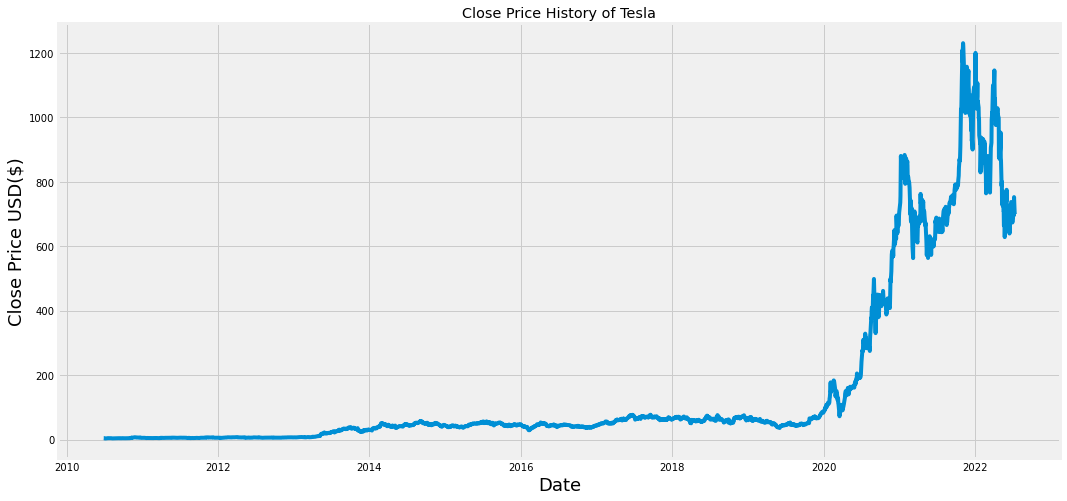

In [12]:
plt.figure(figsize=(16,8))
plt.title('Close Price History of Tesla')
plt.plot(tesla_price['close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.show()

In [13]:
data = tesla_price.drop(['financeType','open', 'high', 'low', 'adjustedClose', 'volume','id'], axis = 1)
price_column = 'close'
data.head()

,close
date,
2010-06-29,4.778
2010-06-30,4.766
2010-07-01,4.392
2010-07-02,3.840
2010-07-06,3.222


In [14]:
# This function splits the data in 70,30 ratio.
def train_test_split(df, test_size=0.3):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [15]:
train, test = train_test_split(data, test_size=0.2)

In [16]:
train.shape, test.shape

((2424, 1), (606, 1))

In [17]:
train

,close
date,
2010-06-29,4.778000
2010-06-30,4.766000
2010-07-01,4.392000
2010-07-02,3.840000
2010-07-06,3.222000
...,...
2020-02-07,149.613998
2020-02-10,154.255997
2020-02-11,154.876007


In [18]:
test

,close
date,
2020-02-14,160.005997
2020-02-18,171.679993
2020-02-19,183.483994
2020-02-20,179.882004
2020-02-21,180.199997
...,...
2022-07-06,695.200012
2022-07-07,733.630005
2022-07-08,752.289978


In [19]:
# Perform MinMax scaling
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(data).reshape(-1,1))
df1

array([[0.00131893],
       [0.00130915],
       [0.00100428],
       ...,
       [0.61066228],
       [0.57050745],
       [0.56739352]])

In [20]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.8)
# test_size=len(df1)-training_size

test_size = 0.2
split_row = len(df1) - int(test_size * len(df1))
# train_data = df.iloc[:split_row]
# test_data = df.iloc[split_row:]
    
train_scaled,test_scaled=df1[0:split_row,:],df1[split_row:,]
training_size,split_row

(2424, 2424)

In [21]:
train_scaled.shape,test_scaled.shape

((2424, 1), (606, 1))

In [22]:
train_scaled

array([[0.00131893],
       [0.00130915],
       [0.00100428],
       ...,
       [0.12367312],
       [0.12251721],
       [0.12850214]])

In [23]:
test_scaled

array([[0.1278549 ],
       [0.13737109],
       [0.14699327],
       [0.14405706],
       [0.14431628],
       [0.13335887],
       [0.12783533],
       [0.12439372],
       [0.10812309],
       [0.10632811],
       [0.11865824],
       [0.11896638],
       [0.11961687],
       [0.11554759],
       [0.11211412],
       [0.09654778],
       [0.10263378],
       [0.10082413],
       [0.0888119 ],
       [0.08654086],
       [0.06998492],
       [0.06756063],
       [0.05631465],
       [0.06714326],
       [0.06712533],
       [0.06822743],
       [0.07975545],
       [0.08533931],
       [0.08353128],
       [0.08128143],
       [0.07928755],
       [0.08285307],
       [0.07593397],
       [0.07151742],
       [0.07568127],
       [0.08158793],
       [0.08635011],
       [0.08690279],
       [0.09084165],
       [0.10355003],
       [0.11315915],
       [0.11641003],
       [0.11891747],
       [0.12033258],
       [0.11910495],
       [0.10938169],
       [0.11678173],
       [0.112

In [24]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [25]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 30
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, ytest = create_dataset(test_scaled, time_step)

In [26]:
print(X_train.shape), print(y_train.shape)

(2393, 30)
(2393,)


(None, None)

In [27]:
print(X_test.shape), print(ytest.shape)

(575, 30)
(575,)


(None, None)

In [28]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [29]:
print(X_train.shape), print(y_train.shape)

(2393, 30, 1)
(2393,)


(None, None)

In [30]:
print(X_test.shape), print(ytest.shape)

(575, 30, 1)
(575,)


(None, None)

In [31]:
X_test

array([[[0.1278549 ],
        [0.13737109],
        [0.14699327],
        ...,
        [0.08533931],
        [0.08353128],
        [0.08128143]],

       [[0.13737109],
        [0.14699327],
        [0.14405706],
        ...,
        [0.08353128],
        [0.08128143],
        [0.07928755]],

       [[0.14699327],
        [0.14405706],
        [0.14431628],
        ...,
        [0.08128143],
        [0.07928755],
        [0.08285307]],

       ...,

       [[0.54757694],
        [0.50947622],
        [0.5344528 ],
        ...,
        [0.55319336],
        [0.56738536],
        [0.56412471]],

       [[0.50947622],
        [0.5344528 ],
        [0.57433867],
        ...,
        [0.56738536],
        [0.56412471],
        [0.59545138]],

       [[0.5344528 ],
        [0.57433867],
        [0.6166456 ],
        ...,
        [0.56412471],
        [0.59545138],
        [0.61066228]]])

In [32]:
ytest

array([0.07928755, 0.08285307, 0.07593397, 0.07151742, 0.07568127,
       0.08158793, 0.08635011, 0.08690279, 0.09084165, 0.10355003,
       0.11315915, 0.11641003, 0.11891747, 0.12033258, 0.11910495,
       0.10938169, 0.11678173, 0.11246464, 0.11564703, 0.12764622,
       0.12281557, 0.12793316, 0.12489587, 0.11176198, 0.12152272,
       0.12266721, 0.12500999, 0.12459588, 0.1310161 , 0.12969064,
       0.12938414, 0.12637619, 0.1283929 , 0.12771469, 0.13007214,
       0.1291559 , 0.13038679, 0.1323497 , 0.130602  , 0.13092643,
       0.13114816, 0.12879723, 0.13355614, 0.14384348, 0.14114693,
       0.14137517, 0.13834604, 0.14181537, 0.15229182, 0.15078378,
       0.16454044, 0.15602852, 0.14990503, 0.15897289, 0.15754309,
       0.15911799, 0.1611021 , 0.16060321, 0.15953046, 0.16074669,
       0.15407377, 0.15817077, 0.1538928 , 0.16198084, 0.17346811,
       0.17996005, 0.19447482, 0.22103607, 0.22401628, 0.22010678,
       0.22473689, 0.24925208, 0.24149336, 0.24471162, 0.24947

In [33]:
np.random.seed(42)
tf.random.set_seed(42)
window_len = 30
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
activ_func = "relu"

In [34]:
# model = Sequential()
# model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(dropout))
# model.add(Dense(units=1))
# model.add(Activation(activ_func))
# model.compile(loss=loss, optimizer=optimizer)
# model.summary()

In [35]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/100
75/75 [==============================] - 10s 33ms/step - loss: 9.1537e-05
Epoch 2/100
75/75 [==============================] - 3s 34ms/step - loss: 1.5826e-05
Epoch 3/100
75/75 [==============================] - 2s 33ms/step - loss: 1.3877e-05
Epoch 4/100
75/75 [==============================] - 3s 33ms/step - loss: 1.3756e-05
Epoch 5/100
75/75 [==============================] - 2s 33ms/step - loss: 1.2211e-05
Epoch 6/100
75/75 [==============================] - 3s 33ms/step - loss: 1.3742e-05
Epoch 7/100
75/75 [==============================] - 2s 33ms/step - loss: 1.0340e-05
Epoch 8/100
75/75 [==============================] - 3s 33ms/step - loss: 1.0111e-05
Epoch 9/100
75/75 [==============================] - 3s 34ms/step - loss: 1.0440e-05
Epoch 10/100
75/75 [==============================] - 3s 33ms/step - loss: 8.6374e-06
Epoch 11/100
75/75 [==============================] - 3s 37ms/step - loss: 7.3410e-06
Epoch 12/100
75/75 [==============================] - 3s 35ms/

75/75 [==============================] - 3s 42ms/step - loss: 2.5681e-06
Epoch 97/100
75/75 [==============================] - 3s 39ms/step - loss: 2.0439e-06
Epoch 98/100
75/75 [==============================] - 3s 38ms/step - loss: 2.8188e-06
Epoch 99/100
75/75 [==============================] - 3s 40ms/step - loss: 2.3339e-06
Epoch 100/100
75/75 [==============================] - 3s 38ms/step - loss: 2.1203e-06


In [37]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

18/18 [==============================] - 0s 13ms/step


In [38]:
test_predict

array([[0.08089992],
       [0.07940915],
       [0.08329355],
       [0.07683398],
       [0.07264579],
       [0.07673246],
       [0.08241075],
       [0.08681855],
       [0.08713282],
       [0.0908956 ],
       [0.10336034],
       [0.11285076],
       [0.1161304 ],
       [0.118836  ],
       [0.12066027],
       [0.11994114],
       [0.11084207],
       [0.1184183 ],
       [0.11430888],
       [0.11733036],
       [0.12888831],
       [0.12392776],
       [0.12881698],
       [0.12589234],
       [0.11319923],
       [0.12299699],
       [0.12420679],
       [0.12636444],
       [0.12577733],
       [0.13202202],
       [0.13073286],
       [0.13050935],
       [0.12770373],
       [0.1298619 ],
       [0.1292994 ],
       [0.1316326 ],
       [0.13069971],
       [0.13188477],
       [0.13380444],
       [0.13209166],
       [0.13243712],
       [0.13270094],
       [0.13043071],
       [0.13512339],
       [0.14519322],
       [0.1424453 ],
       [0.14267445],
       [0.139

In [39]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.0013365534345661611

In [40]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.041424346576003836

In [41]:
# Calculate the Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(ytest,test_predict)
mae

0.031108113403139084

In [42]:
# Calculate Mean Absolute error using Sklearn library
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(ytest,test_predict)

0.05514073815262874

In [43]:
# Manual calculation of Mean Absolute Percentage error.
total = 0
for i,j in zip(ytest, test_predict):
    value = abs(i-j)/abs(i)
    total+= value
#     print(total)
error = float(total*100/(len(ytest))) # Calculate MAPE
mape = round(error,2) # round to 3 significant figures
print(mape)

5.51


In [44]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [45]:
test_predict

array([[ 102.403984],
       [ 100.57518 ],
       [ 105.34036 ],
       [  97.416084],
       [  92.27823 ],
       [  97.29155 ],
       [ 104.25739 ],
       [ 109.66466 ],
       [ 110.050186],
       [ 114.66618 ],
       [ 129.9573  ],
       [ 141.59967 ],
       [ 145.62297 ],
       [ 148.94206 ],
       [ 151.18    ],
       [ 150.29779 ],
       [ 139.13551 ],
       [ 148.42966 ],
       [ 143.38843 ],
       [ 147.09502 ],
       [ 161.27374 ],
       [ 155.18839 ],
       [ 161.18623 ],
       [ 157.59845 ],
       [ 142.02716 ],
       [ 154.04657 ],
       [ 155.53069 ],
       [ 158.1776  ],
       [ 157.45735 ],
       [ 165.11803 ],
       [ 163.53656 ],
       [ 163.26236 ],
       [ 159.82056 ],
       [ 162.46811 ],
       [ 161.77806 ],
       [ 164.6403  ],
       [ 163.49588 ],
       [ 164.94965 ],
       [ 167.30461 ],
       [ 165.20345 ],
       [ 165.62726 ],
       [ 165.95088 ],
       [ 163.1659  ],
       [ 168.92262 ],
       [ 181.2758  ],
       [ 1

In [46]:
test_predict.shape

(575, 1)

In [47]:
targets = test[price_column][window_len+1:]
targets

date
2020-03-31    104.800003
2020-04-01     96.311996
2020-04-02     90.893997
2020-04-03     96.001999
2020-04-06    103.248001
                 ...    
2022-07-06    695.200012
2022-07-07    733.630005
2022-07-08    752.289978
2022-07-11    703.030029
2022-07-12    699.210022
Name: close, Length: 575, dtype: float64

In [48]:
preds = pd.Series(index=targets.index, data=test_predict.squeeze())
preds

date
2020-03-31    102.403984
2020-04-01    100.575180
2020-04-02    105.340363
2020-04-03     97.416084
2020-04-06     92.278229
                 ...    
2022-07-06    721.265137
2022-07-07    736.784485
2022-07-08    733.052917
2022-07-11    766.955811
2022-07-12    785.626160
Length: 575, dtype: float32

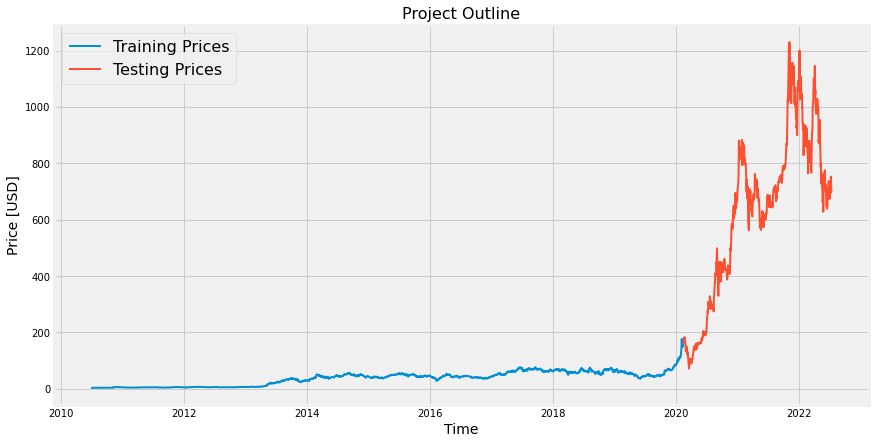

In [49]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Price [USD]', fontsize=14)
    ax.set_xlabel('Time', fontsize = 14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train["close"], test["close"], 'Training Prices', 'Testing Prices', title='Project Outline')

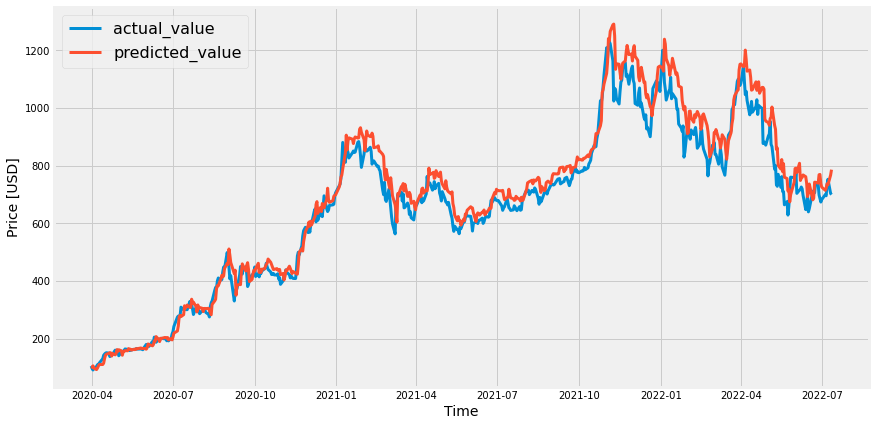

In [50]:
line_plot(targets, preds, 'actual_value', 'predicted_value', lw=3)

### Future Prediction for 30 days

In [51]:
len(test)

606

In [52]:
length = len(test_scaled)
length

606

In [53]:
#Getting the last 100 days records
fut_inp = test_scaled[length-30:]
fut_inp.shape

(30, 1)

In [54]:
fut_inp = fut_inp.reshape(1,-1)

In [55]:
fut_inp.shape

(1, 30)

In [56]:
fut_inp

array([[0.6166456 , 0.61552883, 0.60094557, 0.62917463, 0.5709313 ,
        0.58013451, 0.58161806, 0.58890561, 0.58362337, 0.5653393 ,
        0.5250051 , 0.53760747, 0.56722232, 0.51855714, 0.52750765,
        0.57709392, 0.57477073, 0.57228449, 0.59829629, 0.59637252,
        0.566399  , 0.55619315, 0.54637046, 0.55319336, 0.56738536,
        0.56412471, 0.59545138, 0.61066228, 0.57050745, 0.56739352]])

In [57]:
tmp_inp = list(fut_inp)

In [58]:
tmp_inp

[array([0.6166456 , 0.61552883, 0.60094557, 0.62917463, 0.5709313 ,
        0.58013451, 0.58161806, 0.58890561, 0.58362337, 0.5653393 ,
        0.5250051 , 0.53760747, 0.56722232, 0.51855714, 0.52750765,
        0.57709392, 0.57477073, 0.57228449, 0.59829629, 0.59637252,
        0.566399  , 0.55619315, 0.54637046, 0.55319336, 0.56738536,
        0.56412471, 0.59545138, 0.61066228, 0.57050745, 0.56739352])]

In [59]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [60]:
tmp_inp

[0.6166455952998164,
 0.6155288274481515,
 0.6009455672042803,
 0.6291746310234869,
 0.5709312969947715,
 0.5801345076628708,
 0.581618058467484,
 0.5889056091112365,
 0.5836233748985574,
 0.5653392971497567,
 0.5250050981453651,
 0.5376074707327052,
 0.5672223197183136,
 0.5185571390821743,
 0.5275076511634318,
 0.5770939192001686,
 0.5747707279052743,
 0.5722844936151027,
 0.5982962907339933,
 0.5963725206629993,
 0.5663989979559276,
 0.5561931543423133,
 0.5463704621344238,
 0.5531933639220915,
 0.567385361898429,
 0.5641247139349989,
 0.5954513835375203,
 0.6106622842775483,
 0.5705074461811672,
 0.5673935216699575]

In [61]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=30
i=0
while(i<30):
    
    if(len(tmp_inp)>30):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.5987504720687866], [0.6276208758354187], [0.6555772423744202], [0.682407021522522], [0.7085483074188232], [0.7347962856292725], [0.7617897391319275], [0.7899062037467957], [0.8192934989929199], [0.8499583005905151], [0.8818399906158447], [0.9148595929145813], [0.9489265084266663], [0.9839531183242798], [1.0198668241500854], [1.0565712451934814], [1.0939526557922363], [1.131893277168274], [1.170254111289978], [1.2088717222213745], [1.247575283050537], [1.28618323802948], [1.324499249458313], [1.3623238801956177], [1.3994576930999756], [1.4357091188430786], [1.470903992652893], [1.5048799514770508], [1.5375025272369385], [1.5686700344085693]]


In [62]:
end_date

'2022-07-12'

In [63]:
temp = pd.to_datetime(end_date, format='%Y-%m-%d')
temp
end_date_new = temp.strftime('%m/%d/%Y')
end_date_new

'07/12/2022'

In [64]:
preds = scaler.inverse_transform(lst_output)
preds

array([[ 737.67716197],
       [ 773.09393077],
       [ 807.38940437],
       [ 840.30283685],
       [ 872.37166022],
       [ 904.57136838],
       [ 937.68558838],
       [ 972.1774623 ],
       [1008.22832775],
       [1045.84637415],
       [1084.95723847],
       [1125.46403671],
       [1167.25562648],
       [1210.22452136],
       [1254.2816612 ],
       [1299.30881096],
       [1345.16645769],
       [1391.71011625],
       [1438.76927081],
       [1486.14342634],
       [1533.6230209 ],
       [1580.98533098],
       [1627.98949931],
       [1674.39086635],
       [1719.94477259],
       [1764.41621035],
       [1807.591523  ],
       [1849.27153164],
       [1889.29127756],
       [1927.52601805]])

In [65]:
import datetime
date_future = temp + datetime.timedelta(41)
date_future_str = date_future.strftime('%m/%d/%Y')
date_future_str

'08/22/2022'

In [66]:
c = pd.date_range(start=end_date_new, end=date_future_str, freq='B')
c

DatetimeIndex(['2022-07-12', '2022-07-13', '2022-07-14', '2022-07-15',
               '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21',
               '2022-07-22', '2022-07-25', '2022-07-26', '2022-07-27',
               '2022-07-28', '2022-07-29', '2022-08-01', '2022-08-02',
               '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-08',
               '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12',
               '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18',
               '2022-08-19', '2022-08-22'],
              dtype='datetime64[ns]', freq='B')

In [67]:
len(c)

30

In [68]:
fut_preds = pd.Series(index=c, data=preds.squeeze())
fut_preds

2022-07-12     737.677162
2022-07-13     773.093931
2022-07-14     807.389404
2022-07-15     840.302837
2022-07-18     872.371660
2022-07-19     904.571368
2022-07-20     937.685588
2022-07-21     972.177462
2022-07-22    1008.228328
2022-07-25    1045.846374
2022-07-26    1084.957238
2022-07-27    1125.464037
2022-07-28    1167.255626
2022-07-29    1210.224521
2022-08-01    1254.281661
2022-08-02    1299.308811
2022-08-03    1345.166458
2022-08-04    1391.710116
2022-08-05    1438.769271
2022-08-08    1486.143426
2022-08-09    1533.623021
2022-08-10    1580.985331
2022-08-11    1627.989499
2022-08-12    1674.390866
2022-08-15    1719.944773
2022-08-16    1764.416210
2022-08-17    1807.591523
2022-08-18    1849.271532
2022-08-19    1889.291278
2022-08-22    1927.526018
Freq: B, dtype: float64

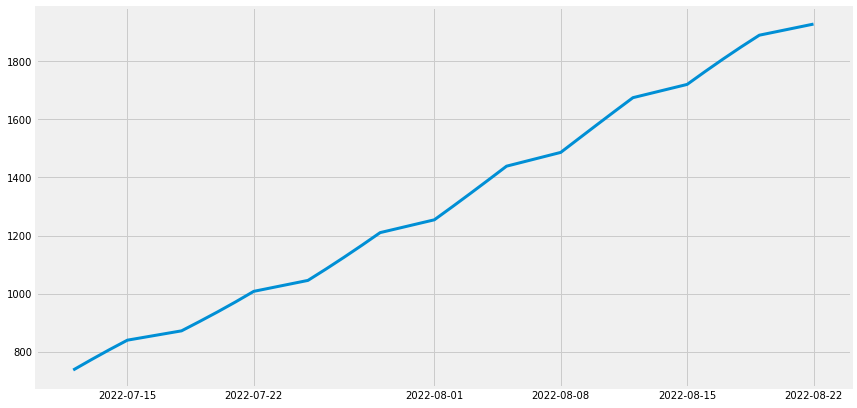

In [69]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(fut_preds, label="predicted value_30", linewidth=3)

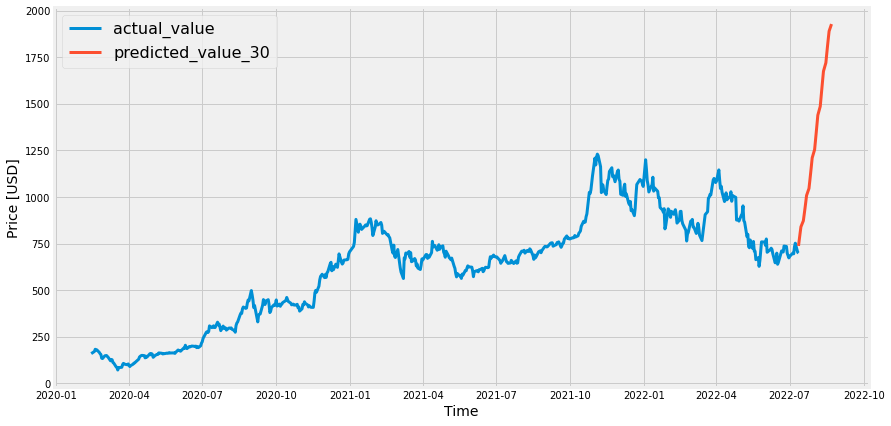

In [70]:
line_plot(test["close"], fut_preds, 'actual_value', 'predicted_value_30', lw=3)